<a href="https://colab.research.google.com/github/sssylvia0/Uplift_Model/blob/main/NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# check pytorch version
import torch
print(torch.__version__)

2.2.1+cu121


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Model Simulation

模型架構圖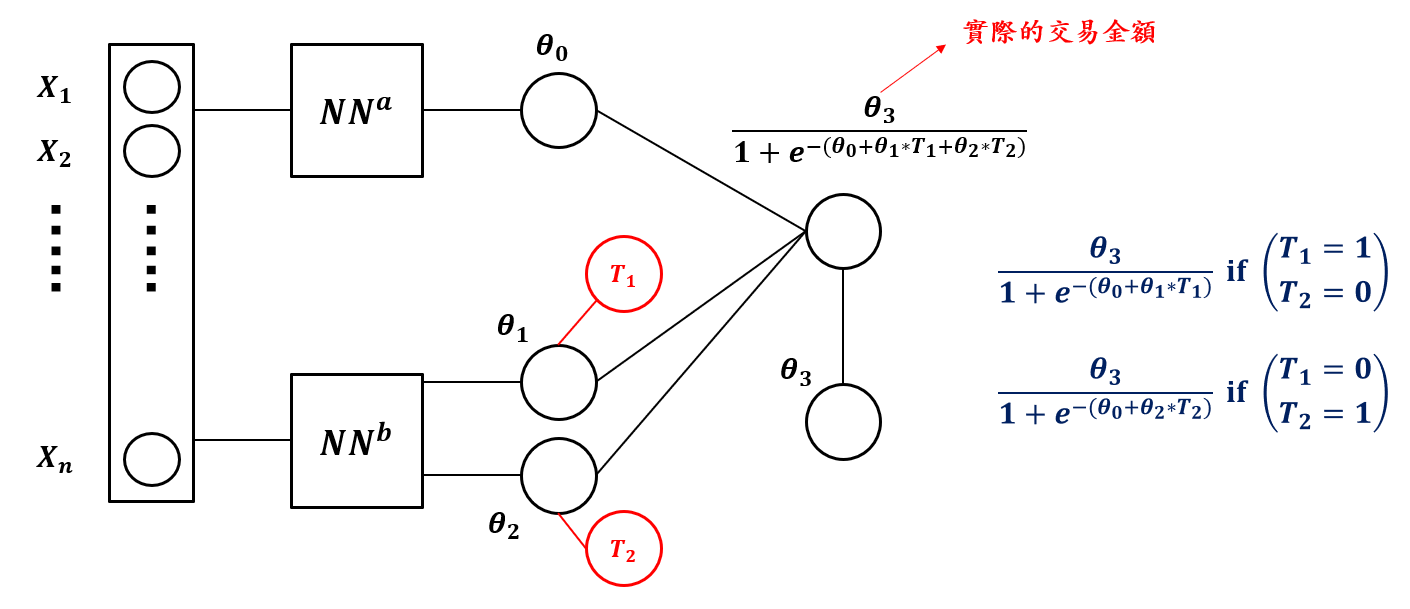

In [3]:
import zipfile

# Specify the path to the zip file
#zip_file_path = 'data202305.csv.zip'
zip_file_path = '/content/drive/MyDrive/Sinopac/Rawdata/data202401.csv.zip'


# Unzip the folder
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall('/content/')
print("Unzipped successfully.")

Unzipped successfully.


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#df = pd.read_csv('/content/drive/MyDrive/Sinopac/train_202402.csv')
df = pd.read_csv('/content/data202401.csv', index_col = 0)
df

,UNINO,年齡,公司戶記號,性別,呆帳記號_含信用卡,客戶年收入,網路會員記號,網路使用記號_行動銀行,小mma記號,網路服務記號,...,客戶行業別_醫療保健,客戶行業別_金融業,客戶行業別_電子業,對帳單寄送記號_0,對帳單寄送記號_1,對帳單寄送記號_2,信用卡VIP客戶註記_Y,外幣存款記號_Y,信用卡轉呆記號_Y,信用卡自動扣款記號_Y
0,F2593340910,18,0,2.0,0,120.0,1,0,0,1,...,0,0,0,0,0,1,0,1,0,0
1,F2593358270,19,0,2.0,0,0.0,1,2,0,3,...,0,0,0,0,0,1,0,0,0,0
2,F2593378680,19,0,2.0,0,50.0,1,0,0,6,...,0,0,0,0,0,1,0,0,0,0
3,F2593397620,19,0,2.0,0,0.0,1,3,0,1,...,0,0,0,0,0,1,0,1,0,0
4,F2598703540,17,0,2.0,0,0.0,1,0,0,1,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1092946,Z1222305990,50,0,1.0,0,600.0,1,3,0,1,...,0,0,0,1,0,0,0,1,0,1
1092947,Y2729592620,60,0,2.0,0,0.0,1,2,0,1,...,0,0,0,0,0,1,0,1,0,0
1092948,Z1222367980,47,0,1.0,0,420.0,1,1,0,1,...,0,0,0,0,0,1,0,1,0,0
1092949,Z1222472300,30,0,1.0,0,550.0,1,1,0,1,...,0,0,1,0,0,1,0,0,0,0


In [5]:
df.select_dtypes(include=['object']).columns

Index(['UNINO'], dtype='object')

In [6]:
binary_columns = []

for column in df.columns:
    unique_values = df[column].unique()
    if len(unique_values) <= 2 and (0 in unique_values or 1 in unique_values):
        binary_columns.append(column)

print("Columns with binary values:")
print(binary_columns)
print(len(binary_columns)) #69

# Convert columns to object data type
df[binary_columns] = df[binary_columns].astype('int64')

Columns with binary values:
['公司戶記號', '呆帳記號_含信用卡', '網路會員記號', '網路使用記號', '薪轉戶記號', '銀行靜止戶記號', '停滯戶記號', '催收記號_不含信用卡', '上市櫃公司員工記號', '存款記號', '信貸記號', '房貸記號', '員工記號', '金控員工記號_非銀行', '證券推介開戶記號', '數位帳戶等級記號', '換匯發送名單', '跨售行為', '近三個月是否發送過外匯名單', '近三個月是否發送過其他名單', '中小企業記號_0', '客戶行業別_住宿及餐飲業', '客戶行業別_保全業', '客戶行業別_保險業', '客戶行業別_公職人員', '客戶行業別_其他', '客戶行業別_典當業', '客戶行業別_各級學校/學術機構', '客戶行業別_外交人員', '客戶行業別_大眾傳播', '客戶行業別_學生', '客戶行業別_家管', '客戶行業別_專業人士', '客戶行業別_廣告業', '客戶行業別_建築業', '客戶行業別_批發及零售業', '客戶行業別_技術服務業', '客戶行業別_投信／投顧／證券', '客戶行業別_政府機構', '客戶行業別_政治人物／演藝人員', '客戶行業別_旅遊業', '客戶行業別_水電燃氣業', '客戶行業別_演藝人員', '客戶行業別_無業', '客戶行業別_營造業', '客戶行業別_礦石及土石採取業', '客戶行業別_社工/義工', '客戶行業別_網路拍賣', '客戶行業別_自由業', '客戶行業別_藝品或寶石交易', '客戶行業別_虛擬貨幣業', '客戶行業別_製造業', '客戶行業別_貿易買賣業', '客戶行業別_資訊業', '客戶行業別_賭博／夜總會相關行業', '客戶行業別_軍官/軍人', '客戶行業別_軍警機構', '客戶行業別_農林漁牧業', '客戶行業別_運輸或倉儲及通訊業', '客戶行業別_醫療保健', '客戶行業別_金融業', '客戶行業別_電子業', '對帳單寄送記號_0', '對帳單寄送記號_1', '對帳單寄送記號_2', '信用卡VIP客戶註記_Y', '外幣存款記號_Y', '信用卡轉呆記號_Y', '信用卡自動扣款記號_Y']
69


In [5]:
num_cols = ['年齡', '薪轉員工平均薪資', '全行往來產品數_持有', '全行往來產品數_使用', '基金近1個月申購次數', '基金近3個月申購次數',
       '基金近6個月申購次數', '基金近12個月申購次數', '最近一個月刷卡筆數', '最近三個月刷卡筆數', '最近六個月刷卡筆數',
       '共同行銷合作推廣_證券', '證券月交易筆數', '證券近一年交易筆數', '證券庫存股檔數', 'TOTALNTAMOUNT',
       '外匯交易金額_近三個月']
#df.select_dtypes(include=['int64']).columns[~df.select_dtypes(include=['int64']).columns.isin(binary_columns)] #111

In [6]:
#1. Minmax
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Exclude non-numeric columns if any
numeric_cols = df.select_dtypes(include=['float64']).columns
df[numeric_cols].append(df[num_cols])
# Initializing MinMaxScaler
scaler = MinMaxScaler()
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

train, test = train_test_split(df, test_size=0.2, random_state=42)
train.drop(['UNINO'], axis = 1, inplace = True)
test.drop(['UNINO'], axis = 1, inplace = True)
print(train.shape, test.shape)

<ipython-input-6-8ad93088cdaa>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df[numeric_cols].append(df[num_cols])


(874360, 204) (218591, 204)


In [8]:
#Normalize
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Exclude non-numeric columns if any
numeric_cols = df.select_dtypes(include=['float64']).columns #139

# Initialize StandardScaler
scaler = StandardScaler()
# Fit scaler on the entire numeric data
scaler.fit(df[numeric_cols])
df[numeric_cols].append(df[num_cols])
# Transform the entire numeric data
df[numeric_cols] = scaler.transform(df[numeric_cols])

# Split the data into training and testing sets
train, test = train_test_split(df, test_size=0.2, random_state=42)
# Drop the 'UNINO' column from both train and test sets
train.drop(['UNINO'], axis=1, inplace=True)
test.drop(['UNINO'], axis=1, inplace=True)

print(train.shape, test.shape)

(174872, 204) (43718, 204)


In [9]:
df[numeric_cols]

,性別,客戶年收入,融資年交易額,融資三月交易額,融資六月交易額,融資庫存市值,融資使用金額,融券庫存市值,融券使用金額,信用卡最近一個月收單手續費收入,...,當年度累計實收保費_要保人,累計實收保費_被保人,累計實收保費_要保人,累計實收保費月平均餘額_要保人,證券月交易額,證券近一年交易額,證券近三個月交易額,證券庫存股股數,證券現股庫存市值,換匯基因標籤
0,-1.022673,-0.013772,-0.0047,-0.00388,-0.003868,-0.004747,-0.004897,-0.005088,-0.005401,-0.006412,...,-0.015095,-0.032525,-0.011786,-0.038239,-0.010905,-0.012398,-0.010349,-0.047330,-0.038055,-1.054458
1,0.972134,0.012612,-0.0047,-0.00388,-0.003868,-0.004747,-0.004897,-0.005088,-0.005401,-0.006412,...,-0.015095,-0.032525,-0.011786,-0.038239,-0.010905,-0.012398,-0.010349,-0.047330,-0.038055,1.600128
2,0.972134,-0.018423,-0.0047,-0.00388,-0.003868,-0.004747,-0.004897,-0.005088,-0.005401,-0.006412,...,-0.015095,-0.032525,-0.011786,-0.038239,-0.010905,-0.012398,-0.010349,-0.047330,-0.038055,0.385239
3,-1.022673,-0.013057,-0.0047,-0.00388,-0.003868,-0.004747,-0.004897,-0.005088,-0.005401,-0.006412,...,-0.015095,-0.032525,-0.011786,-0.038239,-0.010905,-0.012398,-0.010349,-0.047330,-0.038055,-0.820814
4,-1.022673,-0.005646,-0.0047,-0.00388,-0.003868,-0.004747,-0.004897,-0.005088,-0.005401,-0.006412,...,-0.015095,-0.032525,-0.011786,-0.038239,-0.010905,-0.012398,-0.010349,-0.047330,-0.038055,1.720995
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
218585,-1.022673,-0.018423,-0.0047,-0.00388,-0.003868,-0.004747,-0.004897,-0.005088,-0.005401,-0.006412,...,-0.015095,-0.032525,-0.011786,-0.038239,-0.010905,-0.012398,-0.010349,-0.047330,-0.038055,0.307031
218586,-1.022673,-0.018423,-0.0047,-0.00388,-0.003868,-0.004747,-0.004897,-0.005088,-0.005401,-0.006412,...,-0.015095,-0.032525,-0.011786,-0.038239,-0.010905,-0.012398,-0.010349,-0.047330,-0.038055,-0.523918
218587,0.972134,-0.017146,-0.0047,-0.00388,-0.003868,-0.004747,-0.004897,-0.005088,-0.005401,-0.006412,...,-0.015095,-0.032525,-0.011786,-0.038239,0.059401,0.028116,0.039467,1.956853,0.905791,1.287083
218588,0.972134,-0.018423,-0.0047,-0.00388,-0.003868,-0.004747,-0.004897,-0.005088,-0.005401,-0.006412,...,-0.015095,-0.032525,-0.011786,-0.038239,-0.010905,-0.012398,-0.010349,-0.047330,-0.038055,-0.648316


In [9]:
train.iloc[:,150]

122069    0
700537    0
935544    0
733998    0
623164    0
         ..
110268    0
259178    0
131932    0
671155    0
121958    0
Name: TOTALNTAMOUNT, Length: 874360, dtype: int64

In [2]:
import torch
import torch.nn as nn

class CustomNet(nn.Module):
    def __init__(self, input_size):
        super(CustomNet, self).__init__()
        self.fc1_branch1 = nn.Linear(input_size, 1)  # Branch 1 with 1 neuron
        self.fc1_branch2 = nn.Linear(input_size, 2)  # Branch 2 with 2 neurons
        self.fc2 = nn.Linear(3, 1)  # Hidden layer with 1 neuron, merging both branch outputs

    def forward(self, x):
        # Branch 1
        x_branch1 = torch.sigmoid(self.fc1_branch1(x))  # Using all input features for Branch 1

        # Branch 2
        x_branch2 = torch.sigmoid(self.fc1_branch2(x))  # Using all input features for Branch 2
        T1 = x[:, 149].unsqueeze(1)  # Assuming the first feature is used to multiply with the first neuron in Branch 2
        T2 = 1-T1  # Assuming the second feature is used to multiply with the second neuron in Branch 2

        # Element-wise multiplication with the corresponding feature
        T1_multiplied = x_branch2[:, 0].unsqueeze(1) * T1  # Multiply the first neuron with the first feature
        T2_multiplied = x_branch2[:, 1].unsqueeze(1) * T2  # Multiply the second neuron with the second feature

        # Concatenate both branches with the multiplied tensors
        x_concat = torch.cat((x_branch1, T1_multiplied, T2_multiplied), dim=1)

        # Hidden layer
        x_hidden = torch.sigmoid(self.fc2(x_concat))

        # Output layer
        output = torch.sigmoid(x_hidden)
        return output

# Example usage
input_size = 202  # Number of input features
model = CustomNet(input_size)

# Print model architecture
print(model)

CustomNet(
  (fc1_branch1): Linear(in_features=202, out_features=1, bias=True)
  (fc1_branch2): Linear(in_features=202, out_features=2, bias=True)
  (fc2): Linear(in_features=3, out_features=1, bias=True)
)


In [11]:
import torch
import torch.nn as nn
import torch.optim as optim

# If you have labels (target variable) in your DataFrame, you can separate them
# For example, if the last column is the target variable
X_tensor = torch.tensor(train.drop(['TOTALNTAMOUNT','跨售行為'],axis=1).values)  # Exclude the last column
y_tensor = torch.tensor(train['跨售行為'].values)  # Last column as the target variable

# Define the model
input_size = 202 # Number of input features including T1
model = CustomNet(input_size)

# Define the loss function #Binary Cross Entropy Loss
criterion = nn.BCELoss()

# Define the optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Training loop
num_epochs = 50000  # Number of epochs
desired_loss = 0.5  # Desired loss threshold

for epoch in range(num_epochs):
    # Forward pass
    outputs = model(X_tensor.float())  # Convert T1_train to float

    # Compute loss
    loss = criterion(outputs.squeeze(), y_tensor.float())  # Ensure y_tensor is of float type

    # Zero gradients, backward pass, and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print loss every epoch
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

    # Check if the loss is below the desired threshold
    if loss.item() < desired_loss:
        print(f'Loss reached the desired threshold of {desired_loss}. Stopping training...')
        break

Streaming output truncated to the last 5000 lines.
Epoch [45001/50000], Loss: 0.6940
Epoch [45002/50000], Loss: 0.6940
Epoch [45003/50000], Loss: 0.6940
Epoch [45004/50000], Loss: 0.6940
Epoch [45005/50000], Loss: 0.6940
Epoch [45006/50000], Loss: 0.6940
Epoch [45007/50000], Loss: 0.6940
Epoch [45008/50000], Loss: 0.6940
Epoch [45009/50000], Loss: 0.6940
Epoch [45010/50000], Loss: 0.6940
Epoch [45011/50000], Loss: 0.6940
Epoch [45012/50000], Loss: 0.6940
Epoch [45013/50000], Loss: 0.6940
Epoch [45014/50000], Loss: 0.6940
Epoch [45015/50000], Loss: 0.6940
Epoch [45016/50000], Loss: 0.6940
Epoch [45017/50000], Loss: 0.6940
Epoch [45018/50000], Loss: 0.6940
Epoch [45019/50000], Loss: 0.6940
Epoch [45020/50000], Loss: 0.6940
Epoch [45021/50000], Loss: 0.6940
Epoch [45022/50000], Loss: 0.6940
Epoch [45023/50000], Loss: 0.6940
Epoch [45024/50000], Loss: 0.6940
Epoch [45025/50000], Loss: 0.6940
Epoch [45026/50000], Loss: 0.6940
Epoch [45027/50000], Loss: 0.6940
Epoch [45028/50000], Loss: 0.69

In [12]:
# Save the model
torch.save(model.state_dict(), '/content/drive/MyDrive/Model/NN_202401.pth')

In [3]:
# Load the model
model = CustomNet(input_size)
model.load_state_dict(torch.load('/content/drive/MyDrive/Model/NN_202401.pth'))
model.eval()  # Set the model to evaluation mode

CustomNet(
  (fc1_branch1): Linear(in_features=202, out_features=1, bias=True)
  (fc1_branch2): Linear(in_features=202, out_features=2, bias=True)
  (fc2): Linear(in_features=3, out_features=1, bias=True)
)

In [8]:
# Validation
# Assuming you have your test input data X_test in a tensor
test_data = torch.tensor(test.values, dtype=torch.float32)

X_test = torch.tensor(test.drop(['TOTALNTAMOUNT','跨售行為'],axis=1).values)  # Exclude the last column
y_test = torch.tensor(test['跨售行為'].values)  # Last column as the target variable

criterion = nn.BCELoss()

# Set model to evaluation mode
model.eval()

# Pass test data through the model
with torch.no_grad():
    predictions = model(X_test.float())

# Convert predictions to numpy array for further processing if needed
predictions_np = predictions.cpu().numpy()

# Print predictions
print("Predictions:", predictions_np)

# Compute the loss if needed
loss_test = criterion(predictions.squeeze(), y_test.float())
print("Test Loss:", loss_test.item())

# Compute accuracy or other metrics if needed
# For example, for binary classification, you can calculate accuracy
#predicted_labels = (predictions > 0.5).float()  # Convert probabilities to binary predictions
#accuracy = (predicted_labels == y_test).float().mean().item()
#print("Accuracy:", accuracy)

Predictions: [[0.5002746 ]
 [0.5002745 ]
 [0.50027454]
 ...
 [0.50027454]
 [0.5002746 ]
 [0.5002746 ]]
Test Loss: 0.6939337253570557


In [15]:
import numpy as np

# Assuming predictions_np is your NumPy array
mean = np.mean(predictions_np)
median = np.median(predictions_np)
std_dev = np.std(predictions_np)

print("Mean:", mean)
print("Median:", median)
print("Standard Deviation:", std_dev)

Mean: 0.5003968
Median: 0.5002745
Standard Deviation: 0.0004884629


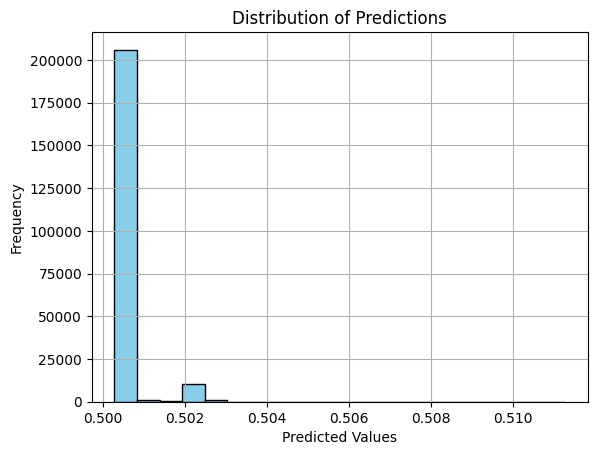

In [16]:
import matplotlib.pyplot as plt

# Assuming predictions_np is your NumPy array
plt.hist(predictions_np, bins=20, color='skyblue', edgecolor='black')  # Adjust the number of bins as needed
plt.title('Distribution of Predictions')
plt.xlabel('Predicted Values')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


###Predictions

In [17]:
import zipfile

# Specify the path to the zip file
#zip_file_path = 'data202305.csv.zip'
zip_file_path = '/content/drive/MyDrive/Sinopac/Rawdata/data202402.csv.zip'


# Unzip the folder
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall('/content/')
print("Unzipped successfully.")

Unzipped successfully.


In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#df = pd.read_csv('/content/drive/MyDrive/Sinopac/train_202402.csv')
df = pd.read_csv('/content/data202402.csv', index_col = 0)
df

,UNINO,年齡,公司戶記號,性別,呆帳記號_含信用卡,客戶年收入,網路會員記號,網路使用記號_行動銀行,小mma記號,網路服務記號,...,客戶行業別_醫療保健,客戶行業別_金融業,客戶行業別_電子業,對帳單寄送記號_0,對帳單寄送記號_1,對帳單寄送記號_2,信用卡VIP客戶註記_Y,外幣存款記號_Y,信用卡轉呆記號_Y,信用卡自動扣款記號_Y
0,F1706395290,37,0,1.0,0,500.0,1,1,0,1,...,0,0,0,0,0,1,0,1,0,0
1,F1706405550,37,0,1.0,0,0.0,1,3,0,1,...,0,0,0,0,0,1,0,1,0,0
2,F1713360850,41,0,1.0,0,0.0,1,3,0,3,...,0,0,0,0,0,1,0,0,0,0
3,F1706408440,37,0,1.0,0,27.0,1,1,0,1,...,0,0,0,1,0,0,0,1,0,1
4,F1713368440,41,0,1.0,0,340.0,1,0,0,1,...,0,0,0,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1103735,X2721994820,33,0,2.0,0,0.0,1,3,0,1,...,0,0,0,0,0,1,0,1,0,0
1103736,Y1221175610,71,0,1.0,0,0.0,1,0,0,8,...,0,0,0,1,0,0,0,0,0,0
1103737,W1223779390,27,0,1.0,0,300.0,1,1,0,1,...,0,0,0,0,0,1,0,1,0,0
1103738,X2725567450,45,0,2.0,0,700.0,1,1,0,1,...,1,0,0,0,0,1,0,0,0,0


In [ ]:
num_cols = ['年齡', '薪轉員工平均薪資', '全行往來產品數_持有', '全行往來產品數_使用', '基金近1個月申購次數', '基金近3個月申購次數',
       '基金近6個月申購次數', '基金近12個月申購次數', '最近一個月刷卡筆數', '最近三個月刷卡筆數', '最近六個月刷卡筆數',
       '共同行銷合作推廣_證券', '證券月交易筆數', '證券近一年交易筆數', '證券庫存股檔數', 'TOTALNTAMOUNT',
       '外匯交易金額_近三個月']
#df.select_dtypes(include=['int64']).columns[~df.select_dtypes(include=['int64']).columns.isin(binary_columns)] #111

In [19]:
#1. Minmax
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Exclude non-numeric columns if any
numeric_cols = df.select_dtypes(include=['float64']).columns
df[numeric_cols].append(df[num_cols])
# Initializing MinMaxScaler
scaler = MinMaxScaler()
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

df.drop(['UNINO'], axis = 1, inplace = True)
print(df.shape)

<ipython-input-19-72b01451df65>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df[numeric_cols].append(df[num_cols])


(1103740, 204)


In [20]:
# Load the model
model = CustomNet(input_size)
model.load_state_dict(torch.load('/content/drive/MyDrive/Model/NN_202401.pth'))
model.eval()  # Set the model to evaluation mode

CustomNet(
  (fc1_branch1): Linear(in_features=202, out_features=1, bias=True)
  (fc1_branch2): Linear(in_features=202, out_features=2, bias=True)
  (fc2): Linear(in_features=3, out_features=1, bias=True)
)

In [21]:
#202402

X_pred = torch.tensor(df.drop(['TOTALNTAMOUNT','跨售行為'],axis=1).values)  # Exclude the last column
y_pred = torch.tensor(df['跨售行為'].values)  # Last column as the target variable

criterion = nn.BCELoss()

# Set model to evaluation mode
model.eval()

# Pass test data through the model
with torch.no_grad():
    predictions = model(X_pred.float())

# Convert predictions to numpy array for further processing if needed
predictions_np = predictions.cpu().numpy()

# Print predictions
print("Predictions:", predictions_np)

# Compute the loss if needed
loss_test = criterion(predictions.squeeze(), y_pred.float())
print("Test Loss:", loss_test.item())

# Compute accuracy or other metrics if needed
# For example, for binary classification, you can calculate accuracy
#predicted_labels = (predictions > 0.5).float()  # Convert probabilities to binary predictions
#accuracy = (predicted_labels == y_test).float().mean().item()
#print("Accuracy:", accuracy)

Predictions: [[0.50027454]
 [0.50027454]
 [0.5002745 ]
 ...
 [0.5002749 ]
 [0.5002745 ]
 [0.5002745 ]]
Test Loss: 0.6939244866371155


In [22]:
import numpy as np

# Assuming predictions_np is your NumPy array
mean = np.mean(predictions_np)
median = np.median(predictions_np)
std_dev = np.std(predictions_np)

print("Mean:", mean)
print("Median:", median)
print("Standard Deviation:", std_dev)

Mean: 0.5003923
Median: 0.5002745
Standard Deviation: 0.00047971745


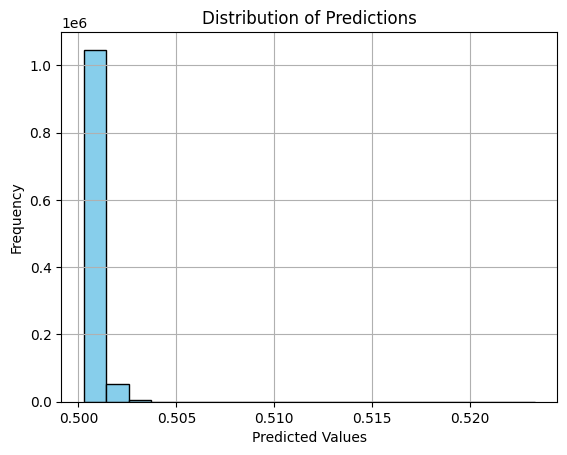

In [23]:
import matplotlib.pyplot as plt

# Assuming predictions_np is your NumPy array
plt.hist(predictions_np, bins=20, color='skyblue', edgecolor='black')  # Adjust the number of bins as needed
plt.title('Distribution of Predictions')
plt.xlabel('Predicted Values')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


In [27]:
import pandas as pd
res = pd.read_csv('/content/data202402.csv', usecols=['UNINO', '換匯基因標籤', '換匯發送名單','TOTALNTAMOUNT', '跨售行為'])
res['NN_lift'] = predictions_np
res

,UNINO,換匯基因標籤,換匯發送名單,TOTALNTAMOUNT,跨售行為,NN_lift
0,F1706395290,87.9483,0,0,0,0.500275
1,F1706405550,59.2382,0,0,0,0.500275
2,F1713360850,50.7072,0,0,0,0.500274
3,F1706408440,98.3747,0,0,0,0.500275
4,F1713368440,79.3979,0,0,0,0.500274
...,...,...,...,...,...,...
1103735,X2721994820,62.4777,0,0,0,0.500275
1103736,Y1221175610,45.0220,0,0,0,0.500274
1103737,W1223779390,78.4204,0,0,0,0.500275
1103738,X2725567450,83.9849,0,0,0,0.500274


In [28]:
res.to_csv('/content/drive/MyDrive/Sinopac/Results/Prediction_results_202402.csv')
#1103740 rows × 6 columns

##Value




> import torch
import torch.nn as nn

### Define the custom layer
class MultiplyByTheta(nn.Module):
    def __init__(self, output_features):
        super(MultiplyByTheta, self).__init__()
        # Initialize theta as a parameter with 1.0 as its initial value
        # This assumes theta is a scalar. Adjust the size for vector outputs.
        self.theta = nn.Parameter(torch.ones(output_features))

    def forward(self, x):
        # Multiply input by theta
        return x * self.theta

### Example usage in a simple model
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        # Example layers: a simple linear layer followed by your custom layer
        self.linear = nn.Linear(in_features=10, out_features=1)  # Example input
        self.multiply_by_theta = MultiplyByTheta(output_features=1)

    def forward(self, x):
        x = self.linear(x)
        x = self.multiply_by_theta(x)
        return x

### Create the model and print it to verify the structure
model = MyModel()
print(model)



In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
df = pd.read_csv('/content/drive/MyDrive/Sinopac/train_202402.csv')
df

,UNINO,年齡,公司戶記號,性別,呆帳記號_含信用卡,客戶年收入,網路會員記號,網路使用記號_行動銀行,小mma記號,網路服務記號,...,客戶行業別_醫療保健,客戶行業別_金融業,客戶行業別_電子業,對帳單寄送記號_0,對帳單寄送記號_1,對帳單寄送記號_2,信用卡VIP客戶註記_Y,外幣存款記號_Y,信用卡轉呆記號_Y,信用卡自動扣款記號_Y
0,F1711372040,42,0,1.0,0,364.0,1,3,0,1,...,0,0,0,0,0,1,0,1,0,0
1,Y2722357310,50,0,2.0,0,2429.0,1,1,0,1,...,0,0,0,0,0,1,0,1,0,0
2,N2738280700,35,0,2.0,0,0.0,1,0,0,6,...,0,0,0,1,0,0,0,1,0,0
3,N1798657360,49,0,1.0,0,420.0,1,3,0,1,...,0,0,0,0,0,1,0,1,0,0
4,T1294962440,69,0,1.0,0,1000.0,1,2,0,1,...,0,0,0,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
218585,E1777416360,49,0,1.0,0,0.0,1,0,0,1,...,0,0,0,1,0,0,0,1,0,0
218586,F1735467240,45,0,1.0,0,0.0,1,3,0,3,...,0,0,0,0,0,1,0,0,0,0
218587,E2789752690,8,0,2.0,0,100.0,1,0,0,3,...,0,0,0,0,0,1,0,0,0,0
218588,B2774924650,26,0,2.0,0,0.0,1,2,0,3,...,0,0,0,0,0,1,0,0,0,0


In [3]:
#1. Minmax
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Exclude non-numeric columns if any
numeric_cols = df.select_dtypes(include=['float64']).columns
# Initializing MinMaxScaler
scaler = MinMaxScaler()
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

train, test = train_test_split(df, test_size=0.2, random_state=42)
train.drop(['UNINO'], axis = 1, inplace = True)
test.drop(['UNINO'], axis = 1, inplace = True)
print(train.shape, test.shape)

(174872, 204) (43718, 204)


In [5]:
train.iloc[:,149]

42035     0
52145     0
142046    0
211846    0
191445    0
         ..
119879    0
103694    0
131932    0
146867    0
121958    0
Name: 換匯發送名單, Length: 174872, dtype: int64

In [6]:
#Normalize
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Exclude non-numeric columns if any
numeric_cols = df.select_dtypes(include=['float64']).columns #139
df[numeric_cols].append(df[num_cols])
# Initialize StandardScaler
scaler = StandardScaler()
# Fit scaler on the entire numeric data
scaler.fit(df[numeric_cols])
# Transform the entire numeric data
df[numeric_cols] = scaler.transform(df[numeric_cols])

# Split the data into training and testing sets
train, test = train_test_split(df, test_size=0.2, random_state=42)
# Drop the 'UNINO' column from both train and test sets
train.drop(['UNINO'], axis=1, inplace=True)
test.drop(['UNINO'], axis=1, inplace=True)

print(train.shape, test.shape)

(174872, 204) (43718, 204)


In [31]:
import torch
import torch.nn as nn

class MultiplyByTheta(nn.Module):
    def __init__(self, theta_value, output_features):
        super(MultiplyByTheta, self).__init__()
        # Initialize theta as a parameter with the provided value
        self.theta = nn.Parameter(torch.tensor(theta_value, dtype=torch.float32))
        self.output_features = output_features

    def forward(self, x):
        # Repeat theta for each sample in the batch
        theta = self.theta.repeat(x.size(0), 1)
        # Multiply input by theta
        return x * theta

class CustomNet(nn.Module):
    def __init__(self, input_size, theta_value):
        super(CustomNet, self).__init__()
        self.fc1_branch1 = nn.Linear(input_size, 1)  # Branch 1 with 1 neuron
        self.fc1_branch2 = nn.Linear(input_size, 2)  # Branch 2 with 2 neurons
        self.multiply_by_theta = MultiplyByTheta(theta_value, output_features=1)

    def forward(self, x):
        # Branch 1
        x_branch1 = torch.sigmoid(self.fc1_branch1(x))  # Using all input features for Branch 1

        # Branch 2
        x_branch2 = torch.sigmoid(self.fc1_branch2(x))  # Using all input features for Branch 2
        T1 = x[:, 149].unsqueeze(1)  # Assuming theta is at index 150
        T2 = 1 - T1  # Complement of T1

        # Element-wise multiplication with the corresponding feature
        T1_multiplied = x_branch2[:, 0].unsqueeze(1) * T1  # Multiply the first neuron with T1
        T2_multiplied = x_branch2[:, 1].unsqueeze(1) * T2  # Multiply the second neuron with T2

        # Concatenate both branches with the multiplied tensors
        x_concat = torch.cat((x_branch1, T1_multiplied, T2_multiplied), dim=1)

        # Apply element-wise multiplication with the custom layer MultiplyByTheta
        x_combined = self.multiply_by_theta(x_concat)

        # Apply sigmoid activation to output
        output = torch.sigmoid(x_combined)
        return output

# Example usage
input_size = 202  # Number of input features
theta_value = train.iloc[:, 150].values.reshape(-1, 1)
model = CustomNet(input_size, theta_value)

# Print model architecture
print(model)

CustomNet(
  (fc1_branch1): Linear(in_features=202, out_features=1, bias=True)
  (fc1_branch2): Linear(in_features=202, out_features=2, bias=True)
  (multiply_by_theta): MultiplyByTheta()
)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

# Assuming you have your input data X, target variable y, and theta values in tensors
X_tensor = torch.tensor(train.drop(['TOTALNTAMOUNT','跨售行為'],axis=1).values, dtype=torch.float32)
y_tensor = torch.tensor(train['TOTALNTAMOUNT'].values, dtype=torch.float32)
theta_tensor = torch.tensor(train['TOTALNTAMOUNT'].values, dtype=torch.float32)

# Define the model
input_size = 202  # Number of input features
model = CustomNet(input_size, theta_tensor)

# Define the loss function: Mean Squared Error (MSE)
criterion = nn.MSELoss()

# Define the optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Training loop
num_epochs = 50000  # Number of epochs
desired_loss = 0.5  # Desired loss threshold

for epoch in range(num_epochs):
    # Forward pass with X_tensor and theta_tensor as inputs
    outputs = model(X_tensor)

    # Compute loss
    loss = criterion(outputs.squeeze(), y_tensor)

    # Zero gradients, backward pass, and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print loss every epoch
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

    # Check if the loss is below the desired threshold
    if loss.item() < desired_loss:
        print(f'Loss reached the desired threshold of {desired_loss}. Stopping training...')
        break

<ipython-input-31-6e1476306715>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.theta = nn.Parameter(torch.tensor(theta_value, dtype=torch.float32))


In [ ]:
# Prediction
# Assuming you have your test input data X_test in a tensor
test_data = torch.tensor(test.values, dtype=torch.float32)

X_test = torch.tensor(test.drop(['TOTALNTAMOUNT','跨售行為'],axis=1).values)  # Exclude the last column
y_test = torch.tensor(test['跨售行為'].values)  # Last column as the target variable


# Set model to evaluation mode
model.eval()

# Pass test data through the model
with torch.no_grad():
    predictions = model(X_test.float())

# Convert predictions to numpy array for further processing if needed
predictions_np = predictions.cpu().numpy()

# Print predictions
print("Predictions:", predictions_np)

# Compute the loss if needed
loss_test = criterion(predictions.squeeze(), y_test.float())
print("Test Loss:", loss_test.item())

# Compute accuracy or other metrics if needed
# For example, for binary classification, you can calculate accuracy
predicted_labels = (predictions > 0.5).float()  # Convert probabilities to binary predictions
accuracy = (predicted_labels == y_test).float().mean().item()
print("Accuracy:", accuracy)

Predictions: [[0.5005014 ]
 [0.5004987 ]
 [0.50050074]
 ...
 [0.5004996 ]
 [0.500499  ]
 [0.5004987 ]]
Test Loss: 0.6941491365432739
Accuracy: 0.0024703782983124256


In [17]:
train[:, 152]

InvalidIndexError: (slice(None, None, None), 152)